# guiding question:

What if we just used the forward model to get exchange between substrate pools and calculate the probabilities based on the proportions of substrate? Like what's the probability of getting a 15NH2OH and a 15NO? Then we can add these to get the total production of 46N2O that we would expect from that combination of processes — and likewise for each of the other isotopomers as well.

# next:
- do we want the nitrite reduction rate constant to be the same kdenitno as the rate constant for no reduction to n2o?
- separate out rate constants for different steps in AOA ammonia oxidation pathway
- clearly the super-high rate constant for hybrid n2o production gives us our separation between alpha and beta but cannot capture the production of 46n2o
- postprocessing scripts to calculate rates in nM/day

# need to add isotope effects for: 
- NITRITE REDUCTION
- SEPARATE ISOTOPE EFFECTS FOR AOA AND AOB

# initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# use for initialization
from collections import namedtuple

# use for plotting interpolations of measured incubation data
import scipy.interpolate as interp

# use for nelder-mead optimization of a convex function
from scipy.optimize import minimize
from numpy.random import rand

import scripts as sc # Python scripts containing helper functions

Set up the model:

In [2]:
### READ IN TRAINING DATA ###
path_to_data = sc.datapath()
filename = '00_incubationdata.csv'

PS2SCM15NO2 = sc.grid_data(filename=f'{path_to_data}{filename}',
                          station="PS2", feature="SCM", tracer="NO2-", 
                          T=1000)

In [3]:
### SUBSTRATE CONCENTRATIONS AND RATES OF EXCHANGE ###
bgc = sc.BioGeoChemistry("PS2SCM", tracer="NO2-")

In [4]:
### ISOTOPE EFFECTS ###
isos = sc.IsotopeEffects()

In [5]:
### MODEL PARAMS ###
(dt, T, times) = sc.modelparams()

### STATE VARIABLES ###
tr = sc.Tracers(bgc, PS2SCM15NO2) 

In [6]:
### INITIAL GUESS FOR OPTIMIZATION ###
x = sc.kestimates(bgc,
                  inputdata=pd.read_csv(f'{sc.datapath()}00_incubationdata.csv'),
                  station="PS2", feature="SCM", hybridtracer="NO2-") 

In [7]:
x

[0.0, 2.8050367317752543e-09, 2.633772229350046e-09, 3.944363997256793e-08]

# model setup

In [8]:
def modelv1(x, tracers):

    ### UNPACK X ###
    [knitrification, kdenitno2, kdenitno3, khybrid] = x

    ### TIME STEPPING ###
    for iT in range(T-1):

        Jhybrid = khybrid*(tracers.nh4_14[iT]+tracers.nh4_15[iT])*(tracers.no2_14[iT]+tracers.no2_15[iT])

        Jnitrification = knitrification*((tracers.nh4_14[iT]+tracers.nh4_15[iT])**2)
        Jdenitno2 = kdenitno2*((tracers.no2_14[iT]+tracers.no2_15[iT])**2)
        Jdenitno3 = kdenitno3*((tracers.no3_14[iT]+tracers.no3_15[iT])**2)

        # update substrate values
        tracers.nh4_14[iT+1,:] = tracers.nh4_14[iT,:] + dt*(
            -bgc.kNH4TONO2*tracers.nh4_14[iT]

            -Jnitrification*(1-tracers.afnh4[iT,:])
            -Jhybrid*(1-tracers.afnh4[iT,:]))

        tracers.nh4_15[iT+1,:] = tracers.nh4_15[iT,:] + dt*(
            -bgc.kNH4TONO2/isos.alpha15NH4TONO2*tracers.nh4_15[iT]

            -Jnitrification*tracers.afnh4[iT,:]
            -Jhybrid*tracers.afnh4[iT,:])

        tracers.no2_14[iT+1,:] = tracers.no2_14[iT,:] + dt*(
            bgc.kNH4TONO2*tracers.nh4_14[iT]
            +bgc.kNO3TONO2*tracers.no3_14[iT]
            -bgc.kNO2TONO3*tracers.no2_14[iT]

            -Jdenitno2*(1-tracers.afno2[iT,:])
            -Jhybrid*(1-tracers.afno2[iT,:]))

        tracers.no2_15[iT+1,:] = tracers.no2_15[iT,:] + dt*(
            bgc.kNH4TONO2/isos.alpha15NH4TONO2*tracers.nh4_15[iT]
            +bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]

            -Jdenitno2*(tracers.afno2[iT,:])
            -Jhybrid*tracers.afno2[iT,:])

        tracers.no3_14[iT+1,:] = tracers.no3_14[iT,:] + dt*(
            bgc.kNO2TONO3*tracers.no2_14[iT]
            -bgc.kNO3TONO2*tracers.no3_14[iT]

            -Jdenitno3*(1-tracers.afno3[iT,:]))

        tracers.no3_15[iT+1,:] = tracers.no3_15[iT,:] + dt*(
            bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]

            -Jdenitno3*tracers.afno3[iT,:])

        # recalculate atom fractions at each time step
        tracers.afnh4[iT+1,:] = tracers.nh4_15[iT+1,:]/(tracers.nh4_14[iT+1,:] + tracers.nh4_15[iT+1,:])
        tracers.afno2[iT+1,:] = tracers.no2_15[iT+1,:]/(tracers.no2_14[iT+1,:] + tracers.no2_15[iT+1,:])
        tracers.afno3[iT+1,:] = tracers.no3_15[iT+1,:]/(tracers.no3_14[iT+1,:] + tracers.no3_15[iT+1,:])

        # calculate total rates of N2O production from substrates

        total_nitrification = Jnitrification/2 # need to multiply by 1/2 to convert nmols N/L/day into nmols N2O/L/day
        total_denit_no2 = Jdenitno2/2
        total_denit_no3 = Jdenitno3/2
        total_hybrid = Jhybrid/2

        # calculate probabilities of isotopomer formation

        p1, p2, p3, p4 = sc.binomial(tracers.afno2[iT], tracers.afnh4[iT])

        p46hybrid = p1
        p45ahybrid = p2 # (p2+p3)/2
        p45bhybrid = p3 # (p2+p3)/2
        p44hybrid = p4

        p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(tracers.afnh4[iT], tracers.afnh4[iT])
        p46no2, p45ano2, p45bno2, p44no2 = sc.binomial(tracers.afno2[iT], tracers.afno2[iT])
        p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(tracers.afno3[iT], tracers.afno3[iT])

        # update N2O values
        tracers.n2o_46[iT+1,:] = tracers.n2o_46[iT,:] + dt*(
            +total_hybrid*p46hybrid
            +total_nitrification*p46nh4
            +total_denit_no2*p46no2
            +total_denit_no3*p46no3
            -bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])

        tracers.n2o_45a[iT+1, :] = tracers.n2o_45a[iT,:] + dt*(
            +total_hybrid*p45ahybrid
            +total_nitrification*p45anh4
            +total_denit_no2*p45ano2
            +total_denit_no3*p45ano3
            -bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT])

        tracers.n2o_45b[iT+1, :] = tracers.n2o_45b[iT,:] + dt*(
            +total_hybrid*p45bhybrid
            +total_nitrification*p45bnh4
            +total_denit_no2*p45bno2
            +total_denit_no3*p45bno3
            -bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2o_44[iT+1,:] = tracers.n2o_44[iT,:] + dt*(
            +total_hybrid*p44hybrid
            +total_nitrification*p44nh4
            +total_denit_no2*p44no2
            +total_denit_no3*p44no3
            -bgc.kN2OCONS*tracers.n2o_44[iT])

        # update N2 values

        tracers.n2_28[iT+1,:] = tracers.n2_28[iT,:] + dt*(bgc.kN2OCONS*tracers.n2o_44[iT])

        tracers.n2_29[iT+1,:] = tracers.n2_29[iT,:] + dt*(
            bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT]
            +bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2_30[iT+1,:] = tracers.n2_30[iT,:] + dt*(bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])
    
    return tracers

In [21]:
def modelv2(x, tracers):

    ### UNPACK X ###
    [knitrification, kdenitno, kdenitno3, khybrid] = x

    ### TIME STEPPING ###
    for iT in range(T-1):

        Jhybrid = khybrid*(tracers.nh2oh_14[iT]+tracers.nh2oh_15[iT])*(tracers.no_14[iT]+tracers.no_15[iT]) 
        
        Jnitrification = knitrification*((tracers.nh4_14[iT]+tracers.nh4_15[iT])**2)
        Jdenitno = kdenitno*((tracers.no_14[iT]+tracers.no_15[iT])**2)
        Jdenitno3 = kdenitno3*((tracers.no3_14[iT]+tracers.no3_15[iT])**2)
        
        kAOA = bgc.kNH4TONO2
        kAOB = bgc.kNH4TONO2

        # update substrate values
        tracers.nh4_14[iT+1,:] = tracers.nh4_14[iT,:] + dt*(
            -kAOB*tracers.nh4_14[iT]
            -kAOA*tracers.nh4_14[iT]
            -Jnitrification*(1-tracers.afnh4[iT,:]))

        tracers.nh4_15[iT+1,:] = tracers.nh4_15[iT,:] + dt*(
            -kAOB/isos.alpha15NH4TONO2*tracers.nh4_15[iT]
            -kAOA/isos.alpha15NH4TONO2*tracers.nh4_15[iT]
            -Jnitrification*tracers.afnh4[iT,:])

        tracers.nh2oh_14[iT+1, :] = tracers.nh2oh_14[iT, :] + dt*(
            +kAOA*tracers.nh4_14[iT]
            -kAOA*tracers.nh2oh_14[iT]
            -Jhybrid*(1-tracers.afnh2oh[iT])
        )

        tracers.nh2oh_15[iT+1, :] = tracers.nh2oh_15[iT, :] + dt*(
            +kAOA/isos.alpha15NH4TONO2*tracers.nh4_15[iT]
            -kAOA/isos.alpha15NH4TONO2*tracers.nh2oh_15[iT]
            -Jhybrid*(tracers.afnh2oh[iT])
        )
            
        tracers.no_14[iT+1, :] = tracers.no_14[iT, :] + dt*(
            +kAOA*tracers.nh2oh_14[iT]
            +kdenitno*tracers.no2_14[iT]
            -kAOA*tracers.no_14[iT]
            -Jdenitno*(1-tracers.afno[iT,:])
            -Jhybrid*(1-tracers.afno[iT])
        )

        tracers.no_15[iT+1, :] = tracers.no_15[iT, :] + dt*(
            +kAOA/isos.alpha15NH4TONO2*tracers.nh2oh_15[iT]
            +kdenitno*tracers.no2_15[iT]
            -kAOA/isos.alpha15NH4TONO2*tracers.no_15[iT]
            -Jdenitno*(tracers.afno[iT,:])
            -Jhybrid*(tracers.afno[iT])
        )
        
        tracers.no2_14[iT+1,:] = tracers.no2_14[iT,:] + dt*(
            +kAOB*tracers.nh4_14[iT]
            +kAOA*tracers.no_14[iT]
            +bgc.kNO3TONO2*tracers.no3_14[iT]
            -bgc.kNO2TONO3*tracers.no2_14[iT]
            -kdenitno*tracers.no2_14[iT]
        )

        tracers.no2_15[iT+1,:] = tracers.no2_15[iT,:] + dt*(
            kAOB/isos.alpha15NH4TONO2*tracers.nh4_15[iT]
            +kAOA/isos.alpha15NH4TONO2*tracers.nh2oh_15[iT]
            +bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -kdenitno*tracers.no2_15[iT]
        )

        tracers.no3_14[iT+1,:] = tracers.no3_14[iT,:] + dt*(
            bgc.kNO2TONO3*tracers.no2_14[iT]
            -bgc.kNO3TONO2*tracers.no3_14[iT]
            -Jdenitno3*(1-tracers.afno3[iT,:]))

        tracers.no3_15[iT+1,:] = tracers.no3_15[iT,:] + dt*(
            bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -Jdenitno3*tracers.afno3[iT,:])

        # recalculate atom fractions at each time step
        tracers.afnh4[iT+1,:] = tracers.nh4_15[iT+1,:]/(tracers.nh4_14[iT+1,:] + tracers.nh4_15[iT+1,:])
        tracers.afnh2oh[iT+1,:] = tracers.nh2oh_15[iT+1,:]/(tracers.nh2oh_14[iT+1,:] + tracers.nh2oh_15[iT+1,:])
        tracers.afno[iT+1,:] = tracers.no_15[iT+1,:]/(tracers.no_14[iT+1,:] + tracers.no_15[iT+1,:])
        tracers.afno2[iT+1,:] = tracers.no2_15[iT+1,:]/(tracers.no2_14[iT+1,:] + tracers.no2_15[iT+1,:])
        tracers.afno3[iT+1,:] = tracers.no3_15[iT+1,:]/(tracers.no3_14[iT+1,:] + tracers.no3_15[iT+1,:])

        # calculate total rates of N2O production from substrates

        total_nitrification = Jnitrification/2 # need to multiply by 1/2 to convert nmols N/L/day into nmols N2O/L/day
        total_denit_no = Jdenitno/2
        total_denit_no3 = Jdenitno3/2
        total_hybrid = Jhybrid/2

        # calculate probabilities of isotopomer formation

        p1, p2, p3, p4 = sc.binomial(tracers.afno[iT], tracers.afnh2oh[iT])

        p46hybrid = p1
        p45ahybrid = p2 # (p2+p3)/2
        p45bhybrid = p3 # (p2+p3)/2
        p44hybrid = p4

        p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(tracers.afnh4[iT], tracers.afnh4[iT])
        p46no, p45ano, p45bno, p44no = sc.binomial(tracers.afno[iT], tracers.afno[iT])
        p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(tracers.afno3[iT], tracers.afno3[iT])

        # update N2O values
        tracers.n2o_46[iT+1,:] = tracers.n2o_46[iT,:] + dt*(
            +total_hybrid*p46hybrid
            +total_nitrification*p46nh4
            +total_denit_no*p46no
            +total_denit_no3*p46no3
            -bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])

        tracers.n2o_45a[iT+1, :] = tracers.n2o_45a[iT,:] + dt*(
            +total_hybrid*p45ahybrid
            +total_nitrification*p45anh4
            +total_denit_no*p45ano
            +total_denit_no3*p45ano3
            -bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT])

        tracers.n2o_45b[iT+1, :] = tracers.n2o_45b[iT,:] + dt*(
            +total_hybrid*p45bhybrid
            +total_nitrification*p45bnh4
            +total_denit_no*p45bno
            +total_denit_no3*p45bno3
            -bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2o_44[iT+1,:] = tracers.n2o_44[iT,:] + dt*(
            +total_hybrid*p44hybrid
            +total_nitrification*p44nh4
            +total_denit_no*p44no
            +total_denit_no3*p44no3
            -bgc.kN2OCONS*tracers.n2o_44[iT])

        # update N2 values

        tracers.n2_28[iT+1,:] = tracers.n2_28[iT,:] + dt*(bgc.kN2OCONS*tracers.n2o_44[iT])

        tracers.n2_29[iT+1,:] = tracers.n2_29[iT,:] + dt*(
            bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT]
            +bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2_30[iT+1,:] = tracers.n2_30[iT,:] + dt*(bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])
    
    return tracers

In [22]:
def objective(x, tracers):
    
    tracers = modelv2(x, tracers)
    
    cost = sc.costfxn(trainingdata = PS2SCM15NO2,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([1,10,10,10]))
    
    return cost

In [88]:
x = [0.00000000e+00, 4.49049767e-05, 4.13859771e-09, 1000]

In [89]:
objective(x, tr)

0.7969790051503554

# optimization

In [103]:
xguess = x

xguess

[0.0, 4.49049767e-05, 4.13859771e-09, 1000]

In [104]:
### OPTIMIZE WITH RANDOMLY SELECTED X0 ###

# define range for input
r_min = np.array(xguess)*0.75
r_max = np.array(xguess)*1.25
# define the starting point as a random sample from the domain
pt = r_min + rand(4)*(r_max - r_min)

pt

array([0.00000000e+00, 5.55223053e-05, 4.81140371e-09, 1.01838812e+03])

In [105]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None))

# perform the search with randomly selected x0
result = minimize(objective, pt, args = tr, method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution, tr)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

<ipython-input-21-6162783a89e3>:9: RuntimeWarning: overflow encountered in multiply
  Jhybrid = khybrid*(tracers.nh2oh_14[iT]+tracers.nh2oh_15[iT])*(tracers.no_14[iT]+tracers.no_15[iT])
<ipython-input-21-6162783a89e3>:12: RuntimeWarning: overflow encountered in square
  Jdenitno = kdenitno*((tracers.no_14[iT]+tracers.no_15[iT])**2)
<ipython-input-21-6162783a89e3>:85: RuntimeWarning: invalid value encountered in true_divide
  tracers.afnh2oh[iT+1,:] = tracers.nh2oh_15[iT+1,:]/(tracers.nh2oh_14[iT+1,:] + tracers.nh2oh_15[iT+1,:])
<ipython-input-21-6162783a89e3>:86: RuntimeWarning: invalid value encountered in true_divide
  tracers.afno[iT+1,:] = tracers.no_15[iT+1,:]/(tracers.no_14[iT+1,:] + tracers.no_15[iT+1,:])
<ipython-input-21-6162783a89e3>:42: RuntimeWarning: invalid value encountered in subtract
  +kAOA*tracers.nh2oh_14[iT]
<ipython-input-21-6162783a89e3>:50: RuntimeWarning: invalid value encountered in subtract
  +kAOA/isos.alpha15NH4TONO2*tracers.nh2oh_15[iT]
<ipython-input-21-6

Status : Maximum number of function evaluations has been exceeded.
Total Evaluations: 801
Solution: f([0.00000000e+00 4.78998577e-05 4.14971827e-09 9.18621053e+03]) = 0.76290


In [20]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None))

# perform the search with intelligently selcted x0
result = minimize(objective, xguess, args = tr, method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution, tr)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Maximum number of function evaluations has been exceeded.
Total Evaluations: 803
Solution: f([0.00000000e+00 4.83982901e-05 4.35731044e-09 8.77930301e+03]) = 0.77775


In [106]:
objective(result.x, tr)

0.762898751422836

In [107]:
result.x

array([0.00000000e+00, 4.78998577e-05, 4.14971827e-09, 9.18621053e+03])

# post-processing

In [120]:
tracers = modelv2(x, tr)

In [121]:
def postprocess(tracers):

    ### CALCULATE OUTPUT ###

    ### ISOTOPE CONSTANTS ###
    R15std = 0.00367647 # air N2
    R18std = 0.00200517 # VSMOW


    nh4_concentration = pd.DataFrame(tracers.nh4_14+tracers.nh4_15, columns={'[NH4+]_nM'})
    d15nh4 = pd.DataFrame((((tracers.nh4_15/(tracers.nh4_14))/R15std)-1)*1000, columns={'d15NH4+'})
    afnh4_df = pd.DataFrame(tracers.afnh4, columns={'AFNH4+'})

    no3_concentration = pd.DataFrame(tracers.no3_14+tracers.no3_15, columns={'[NO3-]_nM'})
    d15no3 = pd.DataFrame((((tracers.no3_15/(tracers.no3_14))/R15std)-1)*1000, columns={'d15NO3-'})
    afno3_df = pd.DataFrame(tracers.afno3, columns={'AFNO3-'})

    no2_concentration = pd.DataFrame(tracers.no2_14+tracers.no2_15, columns={'[NO2-]_nM'})
    d15no2 = pd.DataFrame((((tracers.no2_15/(tracers.no2_14))/R15std)-1)*1000, columns={'d15NO2-'})
    afno2_df = pd.DataFrame(tracers.afno2, columns={'AFNO2-'})

    n2_concentration = pd.DataFrame(tracers.n2_28+tracers.n2_29+tracers.n2_30, columns = {'[N2]_nM'})
    
    nh2oh_concentration = pd.DataFrame(tracers.nh2oh_15+tracers.nh2oh_14, columns = {'[NH2OH]_nM'})
    
    no_concentration = pd.DataFrame(tracers.no_15+tracers.no_14, columns = {'[NO]_nM'})


    d15Na = pd.DataFrame((((tracers.n2o_45a/(tracers.n2o_44))/R15std)-1)*1000, columns={'d15N2Oa'})
    d15Nb = pd.DataFrame((((tracers.n2o_45b/(tracers.n2o_44))/R15std)-1)*1000, columns={'d15N2Ob'})
    d18O = pd.DataFrame((((tracers.n2o_46/(tracers.n2o_44))/R15std)-1)*1000, columns={'d18O'})

    n2o_44 = pd.DataFrame(tracers.n2o_44, columns={'[N2O_44]_nM'})
    n2o_45a = pd.DataFrame(tracers.n2o_45a, columns={'[N2O_45a]_nM'})
    n2o_45b = pd.DataFrame(tracers.n2o_45b, columns={'[N2O_45b]_nM'})
    n2o_46 = pd.DataFrame(tracers.n2o_46, columns={'[N2O_46]_nM'})
    n2o_concentration = pd.DataFrame(tracers.n2o_44+tracers.n2o_45a+tracers.n2o_45b+tracers.n2o_46, columns={'[N2O]_nM'})

    output = nh4_concentration.join([
        d15nh4,afnh4_df,
        no3_concentration, d15no3, afno3_df,
        no2_concentration, d15no2, afno2_df,
        n2o_44, n2o_45a, n2o_45b, n2o_46,
        n2o_concentration,
        nh2oh_concentration,
        no_concentration,
        n2_concentration,
        d15Na, d15Nb, d18O])

    output["Incubation_time_hrs"] = output.index/1000*24
    
    output['check_mass_conservation'] = output.loc[:,['[NH4+]_nM','[NH2OH]_nM','[NO]_nM','[NO3-]_nM','[NO2-]_nM','[N2O]_nM','[N2]_nM','[N2]_nM']].sum(axis=1)
    
    return output
                                                  

In [122]:
output = postprocess(tracers)

In [123]:
print(output['check_mass_conservation'].min())
print(output['check_mass_conservation'].max())

31874.582318890847
31875.363511943997


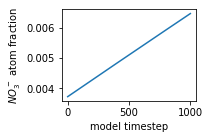

In [124]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(output[['AFNO3-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_3^-$ atom fraction")

plt.tight_layout()
plt.savefig("figures/no3-atomfraction.pdf")

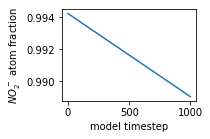

In [125]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(output[['AFNO2-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_2^-$ atom fraction")

plt.tight_layout()
plt.savefig("figures/no2-atomfraction.pdf")

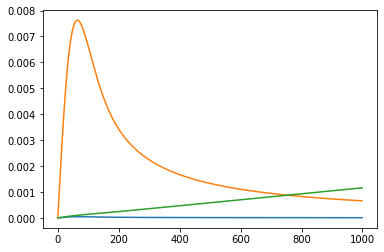

In [133]:
plt.plot(tracers.no_14)
plt.plot(tracers.no_15)
#plt.plot(tracers.nh2oh_14)
plt.plot(tracers.nh2oh_15)

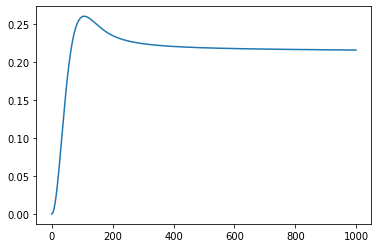

In [134]:
plt.plot(1000*(tracers.nh2oh_14+tracers.nh2oh_15)*(tracers.no_14+tracers.no_15))

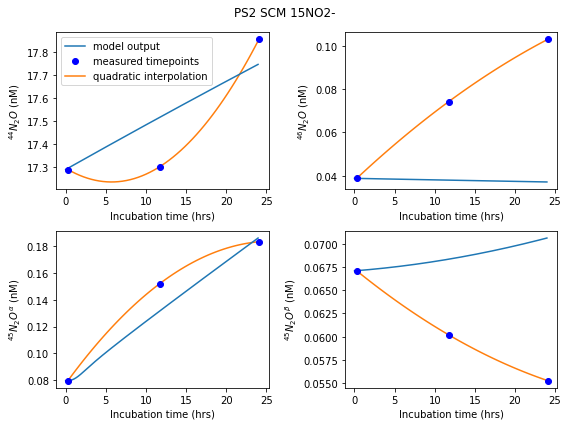

In [135]:
sc.plot_outputs(trainingdata = PS2SCM15NO2, modeloutput=output, 
             filename="Figures/PS2SCM15NO2.pdf")